<a href="https://colab.research.google.com/github/Yuma-Ichikawa/statistical-physics-methods-opt-ml-ja/blob/main/Ex2_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exercise 2.3, Mean field algorithm and State Evolution for the RFIM

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from scipy.signal import find_peaks
from scipy.special import erf

# Defoult Setting
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.size'] = 10  # 適当に必要なサイズに
plt.rcParams['xtick.direction'] = 'in'  # in or out
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.xmargin'] = 0.01
plt.rcParams['axes.ymargin'] = 0.01
plt.rcParams["legend.fancybox"] = False  # 丸角OFF
plt.rcParams["legend.framealpha"] = 1  # 透明度の指定、0で塗りつぶしなし
plt.rcParams["legend.edgecolor"] = 'black'  # edgeの色を変更
plt.rcParams["mathtext.fontset"] = "stix" # stix fontにする(Latexのfont)

plt.style.use('seaborn')

# fix seed
np.random.seed(0)

### 2. Show that indeed it finds configurations with minimum values, that match the replica predictions for the minimum energy when the system is large enough.

In [3]:
class RFIM_state:    
    def __init__(self, N, Δ, S0, field=None):
        """RFIM Instance
    
        Parameters
        ----------
        N : int
            dimension
        Δ : float
            variance of h
        S0 : ndarray of shape (N, )
             initial configuration
        """
        self.N = N
        self.Δ = Δ
        self.S = S0
        self.h = np.random.normal(size=N, scale=np.sqrt(Δ))  
        
        self.m = np.mean(S0)
        self.update_energy()

    def update_magnetization(self):
        # 磁化の更新
        self.m = np.mean(self.S)
        
    def update_energy(self):
        # エネルギー密度の更新(磁化の更新を先に行う)
        self.E = - 0.5*self.m**2 - self.S @ self.h / self.N
    
    def update_greedy_S(self):
        '''1ステップのGreedy Algorithm
                    磁化のUpdateも含む

        Return
        --------
        changed : bool
                   固定点に到達したらfalseとなる
        '''
        newS = np.sign(self.m + self.h)
        changed = not all(newS == self.S)
        self.S = newS
        self.update_magnetization()
        return changed

In [32]:
def optimize_RFIM(rfim, max_iters, track=False):
    """貪欲最適化アルゴリズム
    
    Parameters
    ----------
    rfim : class instance
          RFIM Instance
    max_iters : int
                最大反復回数
    track : bool
            Trueの場合最適化過程をTrackする

    """
    # print(f"【{0}】 E={rfim.E}")
    
    # memory
    ms = [rfim.m]
    Es = [rfim.E]
    t = 0
    changed = True
    while t<max_iters and changed:
        t += 1
        changed = rfim.update_greedy_S()
        if track: 
            ms.append(rfim.m)
            rfim.update_energy()
            Es.append(rfim.E)
        else:
            rfim.update_energy()

    return ms, Es

In [28]:
def MF_energy_T0(m, Δ):
    """基底状態のエネルギーを計算

    Parameters
    --------------
    m : float
        平衡状態の磁化
    Δ : float
        磁場の分散
    """
    return 0.5*m**2 - np.sqrt(2*Δ/np.pi) * np.exp(-m**2/(2*Δ)) - m *erf(m/np.sqrt(2*Δ))

def Iter_eq_RFIM(m0, Δ, max_iters):
    """RFIMのReplica Free Entropyの鞍点方程式を反復法で解く

    Parameters
    --------------
    m0 : float
          反復アルゴリズムの初期値 
    Δ : float
        磁場の分散
    max_iters: int
               最大反復回数
    """
    m = m0
    ms = [m]
    Es = [MF_energy_T0(m, Δ)]
    t = 0
    while t<max_iters:
        t += 1
        m = erf(m/np.sqrt(2*Δ))
        ms.append(m)
        Es.append(MF_energy_T0(m, Δ))

    return ms, Es

(1) : レプリカ計算の結果と有限の$N$のsimulation結果を比較

In [56]:
N = 10**6
deltas = np.arange(0.05,1.2,.05)
m0=0.2
nseeds=10

# +1のスピンの数
p1 = int(N*(1 + m0)/2)
m_means, m_stds = [], []
E_means, E_stds = [], []

for Δ in deltas: 
    m = []
    E = []
    for s in range(nseeds):
        # 確率 p1で+となる状態でランダムに生成
        S = np.random.permutation(np.concatenate((np.ones(p1),-np.ones(N-p1))))
        rfim = RFIM_state(N, Δ, S)
        optimize_RFIM(rfim, 100)
        m.append(rfim.m)
        E.append(rfim.E)
    # randam average
    m_means.append(np.mean(m))
    m_stds.append(np.std(m)/np.sqrt(nseeds))
    E_means.append(np.mean(E))
    E_stds.append(np.std(E)/np.sqrt(nseeds))

# 理論値を計算
m_theory, E_theory = [], []
for Δ in deltas: 
    ms, Es = Iter_eq_RFIM(m0, Δ, 100)
    m_theory.append(ms[-1])
    E_theory.append(Es[-1])

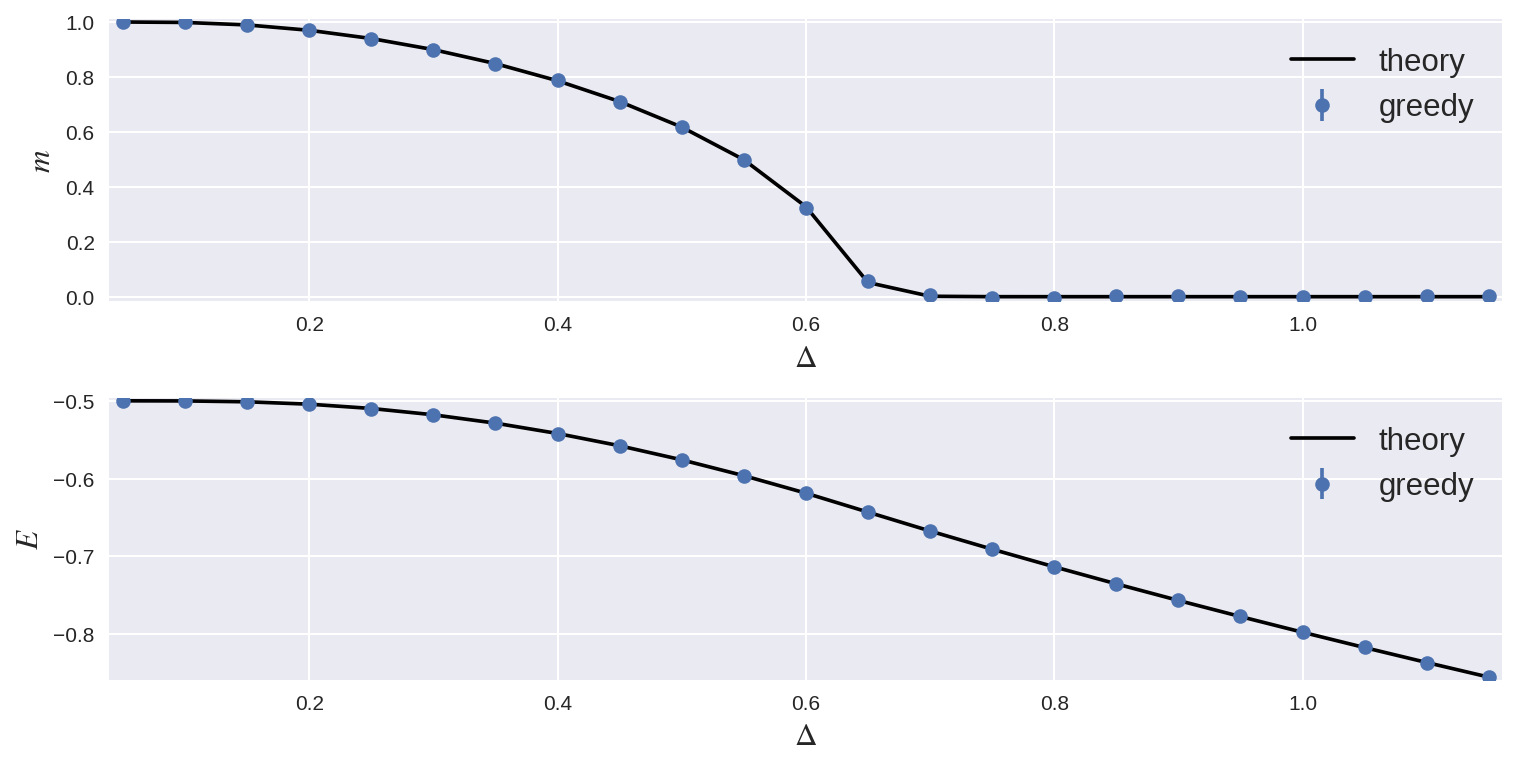

In [59]:

fig, ax = plt.subplots(2,1,figsize=(10,5), constrained_layout=True, dpi=150)
ax[0].errorbar(deltas, m_means, yerr=m_stds, fmt='o', label='greedy')
ax[0].plot(deltas, m_theory, color='k', label='theory')
ax[0].set_xlabel(r'$\Delta$', fontsize=15)
ax[0].legend(fontsize=15)
ax[0].set_ylabel(r'$m$', fontsize=15)

ax[1].errorbar(deltas, E_means, yerr=E_stds, fmt='o', label='greedy')
ax[1].plot(deltas, E_theory, color='k', label='theory')
ax[1].set_xlabel(r'$\Delta$', fontsize=15)
ax[1].legend(fontsize=15)
ax[1].set_ylabel(r'$E$', fontsize=15)
plt.show()

### 3. Show  that  in  the  large $N$ limit,  the  dynamics  of  this  algorithm  obeys  a  ”state  evolution” equation.

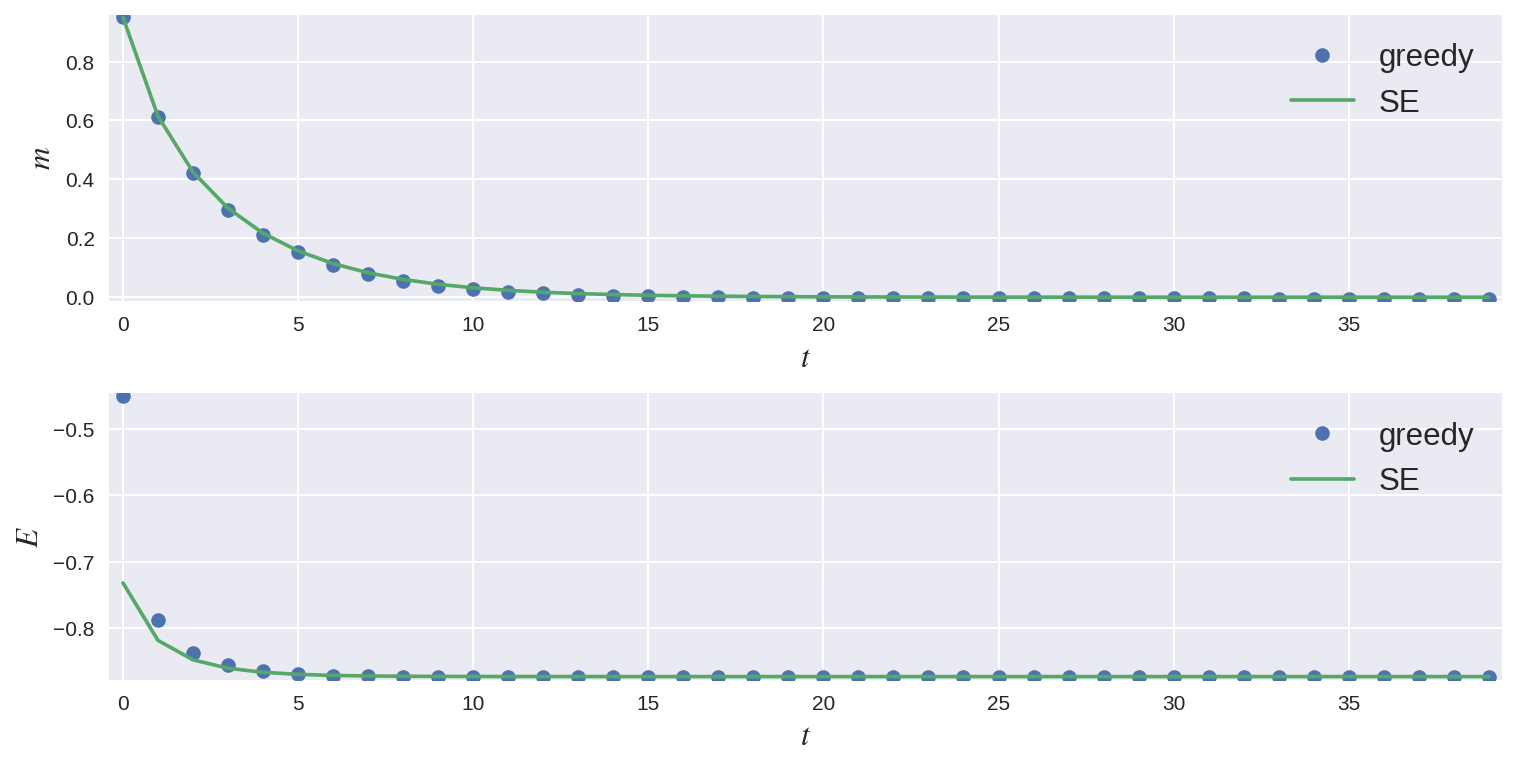

In [55]:
N=10**6
Δ = 1.2
m_init = 0.95
p1 = int(N*(1 + m_init)/2)
S = np.random.permutation(np.concatenate((np.ones(p1),-np.ones(N-p1))))

rfim = RFIM_state(N, Δ, S)
m_init = rfim.m         
ms, Es = optimize_RFIM(rfim, 100, track=True)
ms_SE, Es_SE = Iter_eq_RFIM(m_init, Δ, len(ms)-1)

fig, ax = plt.subplots(2,1,figsize=(10,5), constrained_layout=True, dpi=150)

ax[0].plot(range(len(ms)), ms, 'o', label='greedy')
ax[0].plot(range(len(ms)), ms_SE, label='SE')
ax[0].set_xlabel(r'$t$', fontsize=15)
ax[0].legend(fontsize=15)
ax[0].set_ylabel(r'$m$', fontsize=15)

ax[1].plot(range(len(Es)), Es, 'o', label='greedy')
ax[1].plot(range(len(Es)), Es_SE, label='SE')
ax[1].set_xlabel(r'$t$', fontsize=15)
ax[1].legend(fontsize=15)
ax[1].set_ylabel(r'$E$', fontsize=15)
plt.show()

この結果は, ランダムネス含む最適化アルゴリズムは高次元になると, $h$の分布の分散にのみ依存する決定論的な離散ダイナミクスに収束することを意味している.